# Time Series Analysis of Ethereum (ETH/USDT) Using ARIMA
Objective: Forecast Ethereum price trends using ARIMA on historical data.

In [ ]:
!pip install yfinance statsmodels pmdarima matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load ETH data
eth = yf.download('ETH-USD', start='2020-01-01', end='2024-12-31')
eth = eth[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
eth.index = pd.to_datetime(eth.index)
eth = eth.asfreq('D').fillna(method='ffill')
eth.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,7935230330
2020-01-02,130.820038,130.820038,126.954910,127.410179,8032709256
2020-01-03,127.411263,134.554016,126.490021,134.171707,10476845358
2020-01-04,134.168518,136.052719,133.040558,135.069366,7430904515
2020-01-05,135.072098,139.410202,135.045624,136.276779,7526675353


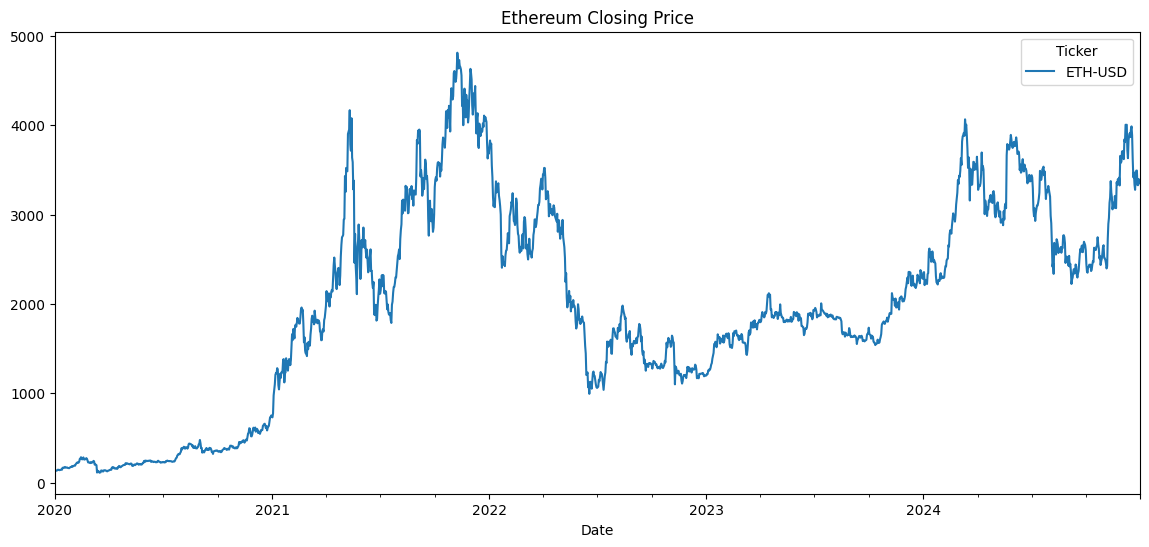

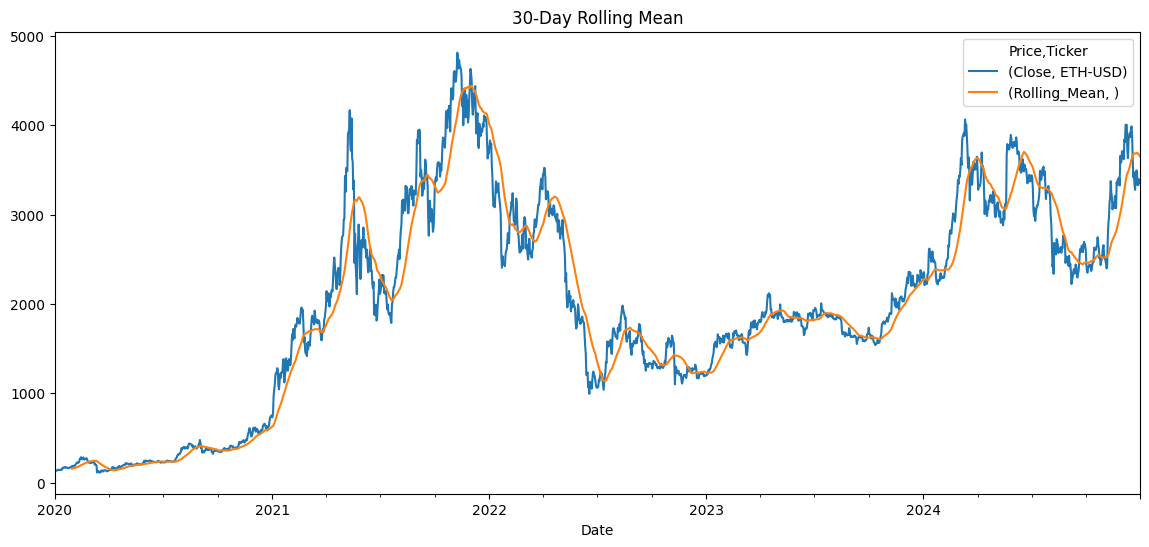

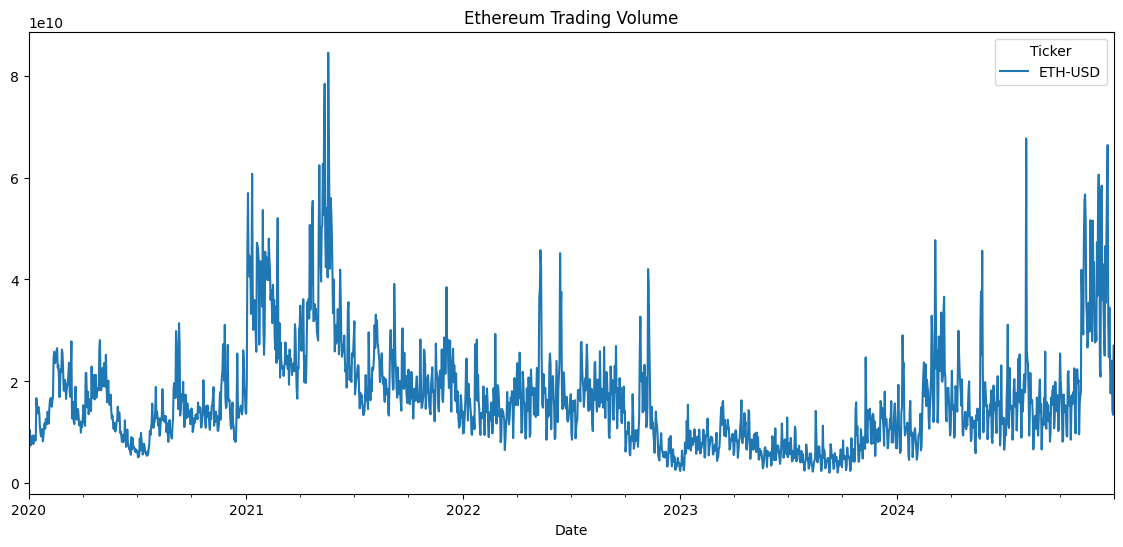

Price,Open,High,Low,Close,Volume,Rolling_Mean
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,
count,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03,1797.000000
mean,1980.032840,2033.090281,1922.570778,1981.600074,1.669406e+10,1983.741987
std,1148.003150,1178.978113,1112.597634,1147.276465,1.053916e+10,1117.277961
min,110.406784,116.021622,95.184303,110.605873,2.081626e+09,136.959600
25%,1250.664185,1281.565033,1211.789398,1251.954102,9.452774e+09,1310.279423
50%,1869.789124,1904.886841,1839.892151,1870.897217,1.459358e+10,1862.963326
75%,2890.993103,2961.298218,2786.070618,2894.424500,2.059002e+10,2873.608952
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10,4442.874154


In [ ]:
# EDA
eth['Close'].plot(figsize=(14, 6), title='Ethereum Closing Price')
plt.show()
eth['Rolling_Mean'] = eth['Close'].rolling(window=30).mean()
eth[['Close', 'Rolling_Mean']].plot(figsize=(14, 6), title='30-Day Rolling Mean')
plt.show()
eth['Volume'].plot(figsize=(14, 6), title='Ethereum Trading Volume')
plt.show()
eth.describe()

In [ ]:
# Stationarity Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary.")
adf_test(eth['Close'])
eth['Close_diff'] = eth['Close'].diff()
adf_test(eth['Close_diff'].dropna())

ADF Statistic: -1.9388719525648033
p-value: 0.31400116530566735
The data is non-stationary.
ADF Statistic: -16.72498773248956
p-value: 1.3983797761380692e-29
The data is stationary.


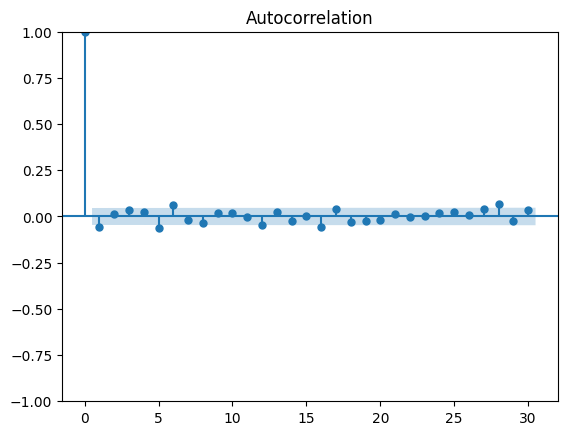

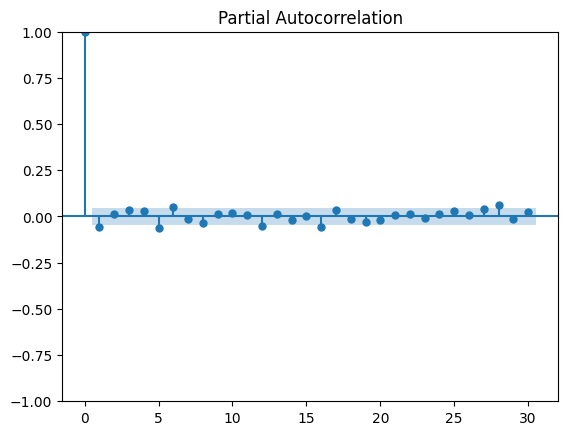

In [ ]:
# ACF and PACF
plot_acf(eth['Close_diff'].dropna(), lags=30)
plot_pacf(eth['Close_diff'].dropna(), lags=30)
plt.show()

In [ ]:
# Fit ARIMA
model = ARIMA(eth['Close'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1826
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10858.888
Date:                Mon, 02 Jun 2025   AIC                          21723.777
Time:                        08:37:24   BIC                          21740.305
Sample:                    01-01-2020   HQIC                         21729.874
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1592      0.245     -0.651      0.515      -0.639       0.320
ma.L1          0.1052      0.247      0.425      0.671      -0.380       0.590
sigma2      8641.2504    123.189     70.146      0.0

RMSE: 248.44523996500055, MAPE: 6.166932411125851%


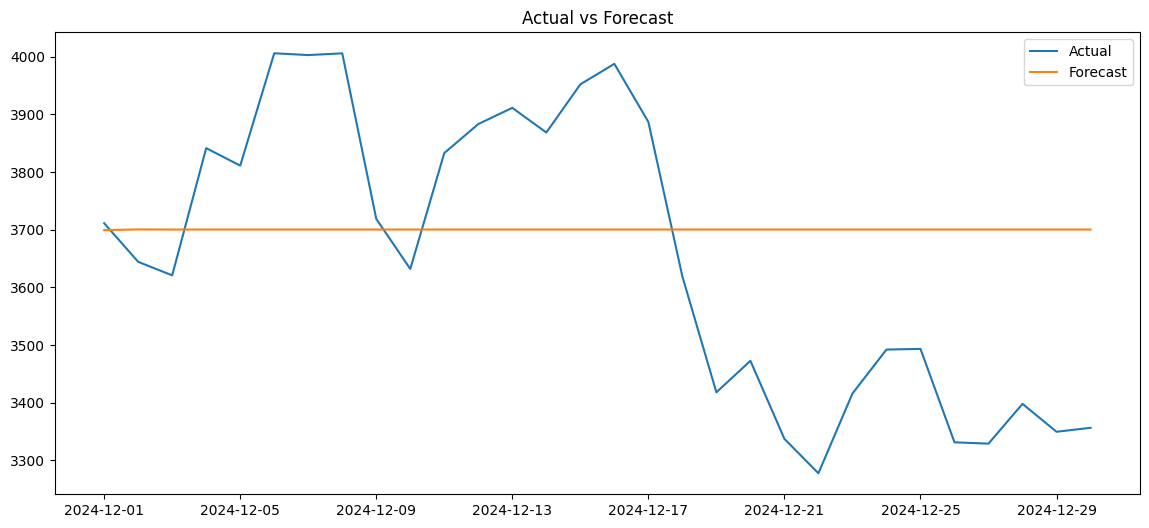

In [ ]:
# Train-Test Split and Evaluation
train = eth['Close'][:-30]
test = eth['Close'][-30:]
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f'RMSE: {rmse}, MAPE: {mape}%')
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('Actual vs Forecast')
plt.show()

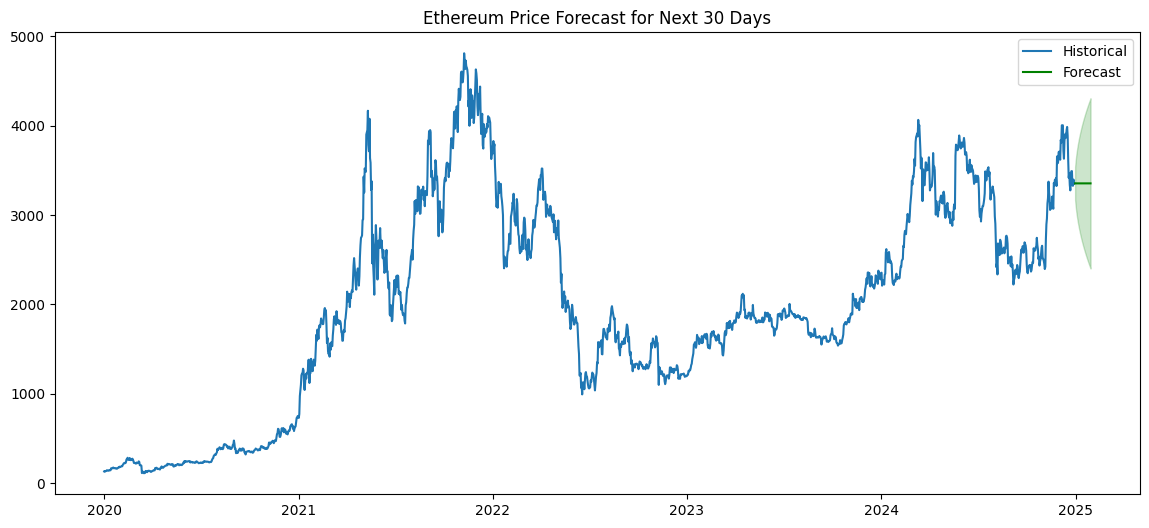

In [ ]:
# Forecast Next 30 Days
final_model = ARIMA(eth['Close'], order=(1, 1, 1)).fit()
forecast = final_model.get_forecast(steps=30)
forecast_df = forecast.summary_frame()
plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Historical')
plt.plot(forecast_df['mean'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='green', alpha=0.2)
plt.legend()
plt.title('Ethereum Price Forecast for Next 30 Days')
plt.show()